In [1]:
import os, json, re
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from labellines import labelLines

from utils.cs_utils import *
from utils.pauli_utils import *
from utils.shadow_utils import *

from scipy.spatial import ConvexHull

In [2]:
err_key = ['MAE', 'MRE', 'RMSE', 'RRMSE', 'Huber', 'Rel. Huber', 'SNR (dB)', 'Ljung']
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X']
models = {'heis': 'Heisenberg', 'tfim': 'TFIM'}

plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.fontsize'] = 12
# plt.rcdefaults()

In [3]:
def sci_notation_labels(values, base=10, dollar=True):
    """Return labels in form 'a × 10^{b}' for given tick values."""
    labels = []
    for v in values:
        if v == 0:
            labels.append("0")
            continue
        exp = int(np.floor(np.log10(abs(v))))
        coeff = v / (base**exp)
        # round coeff to avoid long decimals
        coeff_str = f"{coeff:.2g}"
        if coeff_str == "1":
            if dollar:
                labels.append(rf"$10^{{{exp}}}$")
            else:
                labels.append(f"10^{{{exp}}}")
        else:
            if dollar:
                labels.append(rf"${coeff_str}×10^{{{exp}}}$")
            else:
                labels.append(f"{coeff_str}×10^{{{exp}}}")
    return labels

def match(d, target_params):
    """Return True iff d matches all (k, v) in target_params."""
    return all(k in d and d[k] == v for k, v in target_params.items())

def find_run_id(run_dir: Path, target_params):
    candidates = []

    for p in run_dir.glob("params_*.json"):
        d = json.loads(p.read_text())
        if not match(d, target_params):
            continue

        m = re.search(r"params_(\d+)\.json$", p.name)
        if not m:
            raise ValueError(f"Could not parse run id from {p.name}")
        run_id = int(m.group(1))

        # Choose the timestamp based on cs_params for this run_id
        cs_files = list(run_dir.glob(f"cs_{run_id:04d}*"))
        if not cs_files:
            # If you prefer: skip these instead of erroring
            raise ValueError(f"Matched params for run_id={run_id:04d} but no cs_params_{run_id:04d}* found")

        cs_mtime = max(f.stat().st_mtime for f in cs_files)
        candidates.append((cs_mtime, run_id))

    if not candidates:
        raise ValueError("No params_*.json matched target_params.")

    if len(candidates) > 1:
        print(f"Warning: multiple params_*.json matched target_params. Choosing the one with most recently modified cs_*:")
        for mtime, run_id in candidates:
            print(f"  run_id={run_id:04d}, cs_mtime={mtime}")

    # Return the run_id whose cs_params_* was modified most recently
    candidates.sort(key=lambda x: x[0])
    return candidates[-1][1]


In [4]:
#specify info
NX = 2
NY = 3
HAM = 'heis'
ISTATE = '+-+-+-'

LABEL = f"{NX}x{NY}_{HAM}_{ISTATE}"
DIR = Path("data") / LABEL

exacts = np.load(DIR / 'exacts.npy')
ests = np.load(DIR / 'ests.npy')
errs = np.load(DIR / 'errs.npy')
info = json.load(open(DIR / 'info.json', 'r'))

Nq = NX * NY
Nb = info['nb']
NSMIN = info['nsmin']
NSMAX = info['nsmax']
NSNUM = info['nsnum']
TMIN = info['tmin']
TMAX = info['tmax']
N = info['n']
DT = info['dt']
# NW = info['nw']

times = np.linspace(TMIN, TMAX, N)
shadow_subs = np.round(np.logspace(np.log10(NSMIN),np.log10(NSMAX),NSNUM)).astype(int)
ostrings = pbw(Nq, nb=Nb, max=True)
NUM_PAULIS = len(ostrings)

In [6]:
params = {
    'mmin': 50,
    'mmax': 1000,
    'mnum': 30,
    'amin': -7,
    'amax': -2,
    'anum': 40,
    'snr': -1,
    'rescale': False,
    'axis': 1,
    'inverse': False,
    'fitint': True,
    'replace': False,
    }

RUN_DIR = DIR / "runs"
run_id = find_run_id(RUN_DIR, params) #find run_id that matches params
print("Loaded run id: ", run_id)
cs_errs = np.load(RUN_DIR / f"cs_{run_id:04d}.npy", mmap_mode='r')

params_str = 'mmin={mmin}_mmax={mmax}_mnum={mnum}_amin={amin}_amax={amax}_anum={anum}_snr={snr}_rs={rescale:d}_ax={axis}_inv={inverse:d}_fi={fitint:d}_rp={replace:d}'.format(**params)
PLOT_DIR = Path("plots/") / LABEL
PLOT_DIR_CS = PLOT_DIR / params_str
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR_CS, exist_ok=True)

MNUM = params['mnum']
MMIN = params['mmin']
MMAX = params['mmax']
AMIN = params['amin']
AMAX = params['amax']
ANUM = params['anum']
times_subs = np.round(np.logspace(np.log10(MMIN),np.log10(MMAX),MNUM)).astype(int)
alphas = np.logspace(AMIN, AMAX, ANUM, base=10)

Loaded run id:  1


In [7]:
def plot_observables(times, Ostrings, exacts, ests, cs_ests=None):
    fig = plt.figure(figsize=(20,8))
    assert exacts.shape[1] == ests.shape[1] == len(Ostrings)
    for ii in range(len(Ostrings)):
        ax = plt.subplot(len(Ostrings), 1, ii+1)
        ax.plot(times, ests[:,ii], label='ST', color=f'C1', linewidth=3, alpha=0.75)
        if cs_ests is not None:
            assert cs_ests.shape[0] == len(Ostrings)
            ax.plot(times, cs_ests[ii,:], label=f'CSST', color=f'C2', linewidth=3, alpha=0.75)

        ax.plot(times, exacts[:,ii], label='Exact', color='black', linewidth=0.7, alpha=1)
        ax.set_ylabel(fr"$\langle {Ostrings[ii]} \rangle$")
        ax.set_yticks([-1, 0, 1])
        if ii == 0:
            ax.legend(loc='lower right')
            ax.set_yticklabels(["   ", 0, 1])
        if ii == len(Ostrings)-1:
            ax.set_xlabel("Time")
            ax.set_yticklabels([-1, 0, "   "])
        if ii != len(Ostrings)-1:
            ax.set_xticklabels([])
        if ii != 0 and ii != len(Ostrings)-1:
            ax.set_yticklabels(["   ", "   ", "   "])
        ax.grid()
    fig.subplots_adjust(hspace=0)
    return fig

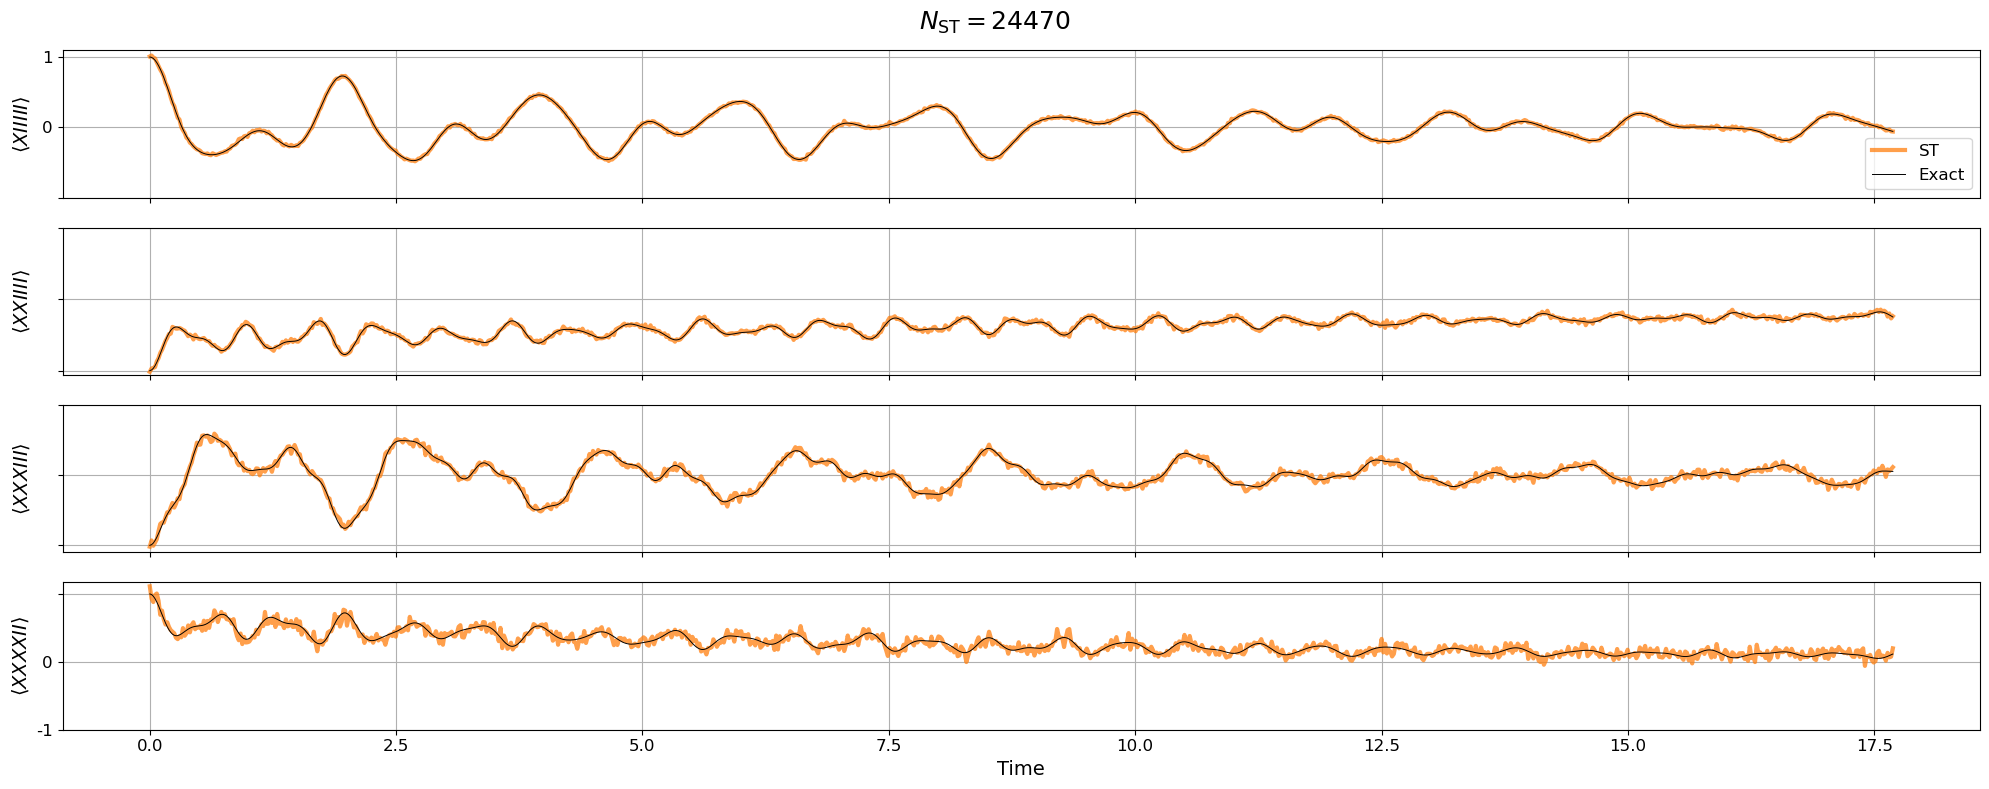

In [8]:
ostrings_to_plot = ['XIIIII', 'XXIIII', 'XXXIII', 'XXXXII']
# ostrings_to_plot = ['YIIIII', 'YYIIII', 'YYYIII', 'YYYYII']
# ostrings_to_plot = ['ZIIIII', 'ZZIIII', 'ZZZIII', 'ZZZZII']

# ostrings_to_plot = ['XIII', 'XXII', 'XXXI', 'XXXX']
# ostrings_to_plot = ['YIII', 'YYII', 'YYYI', 'YYYY']
# ostrings_to_plot = ['ZIII', 'ZZII', 'ZZZI', 'ZZZZ']

oinds = np.array([ostrings.index(s) for s in ostrings_to_plot], dtype=int)
sind = -4
fig = plot_observables(times, ostrings_to_plot, exacts[:,oinds], ests[:,oinds,sind])
fig.suptitle(fr"$N_{{\text{{ST}}}}={shadow_subs[sind]}$")
# plt.savefig(f'./plots/{LABEL}/examples.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [9]:
def compressibility(exacts, filedir=None, filename=None):
    reps = np.zeros((N,len(ostrings)),dtype=complex)
    for oind in range(len(ostrings)):
        reps[:,oind] = sp.fftpack.dct(exacts[:,oind],norm='ortho')

    ss = np.logspace(np.log10(1),np.log10(N),50).astype(int)
    ss = np.unique(ss)
    
    truncs = np.zeros((len(ss),*exacts.shape),dtype=complex)
    recons = np.zeros((len(ss),*exacts.shape))

    for ii in tqdm(range(len(ss))):
        s = ss[ii]
        for oind in range(len(ostrings)):
            temp = np.copy(reps[:,oind])
            temp = np.where(np.abs(temp) >= np.sort(np.abs(temp))[-s], temp, 0)
            truncs[ii,:,oind] = temp
            recons[ii,:,oind] = sp.fftpack.idct(temp, norm='ortho', type=2, axis=0)

    ferrs = np.linalg.norm(truncs-reps, ord=2, axis=1) 
    nferrs = ferrs / np.sqrt(N)

    start,stop = 25,35
    xs = np.log10(ss[start:stop])
    ys = np.log10(np.mean(nferrs[start:stop,:],axis=1)/np.sqrt(N))
    m,b = np.polyfit(xs,ys,1)

    fig = plt.figure(figsize=(6,6))
    legend_lines = []
    for w, inds in enumerate(get_inds(Nq)):
        if 1 <= w <= Nb:
            ys = nferrs[:,inds]
            means = np.mean(ys, axis=1)
            ll, = plt.plot(ss,means,label=f'{w}',marker=markers[w-1],markerfacecolor='none',markersize=6)
            legend_lines.append(ll)
    plt.plot(ss[start-18:],10**(np.polyval([m,b],np.log10(ss[start-18:]))) * 120, color='black', linestyle='-', alpha=0.35, linewidth=3, zorder=0, label=f'$s^{{{m:.1f}}}$')
    labelLines([plt.gca().get_lines()[-1]], xvals=[100], fontsize=12)

    plt.xscale('log')
    plt.xlabel(r'$s$')
    plt.yscale('log')
    plt.ylim(bottom=1e-6)
    plt.legend(handles=legend_lines, labels=[h.get_label() for h in legend_lines], title='Pauli weight', loc='lower left')
    plt.ylabel(r"RMS Error")
    plt.grid()

    if filedir is not None:
        filedir = Path(filedir)
        filedir.mkdir(parents=True, exist_ok=True)
        if filename is None:
            out = filedir / "compressibility.png"
        else:
            out = filedir / filename
        plt.savefig(out, dpi=300, bbox_inches="tight")
    return fig

  0%|          | 0/42 [00:00<?, ?it/s]/var/folders/2q/925k9byj00g101q99sk75gxh0000gn/T/ipykernel_71909/2827232635.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  recons[ii,:,oind] = sp.fftpack.idct(temp, norm='ortho', type=2, axis=0)
100%|██████████| 42/42 [00:04<00:00,  9.72it/s]


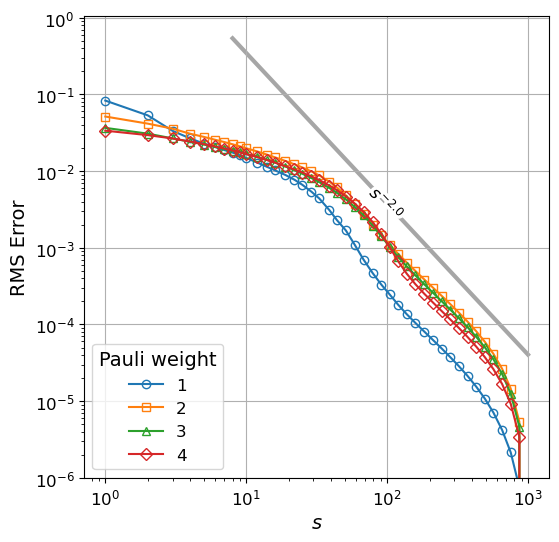

In [10]:
fig = compressibility(exacts, filedir=PLOT_DIR)
plt.show()

In [11]:
def LB(epsilon, delta, w):
    sigma = 3**w
    a = -3**w
    b = 3**w
    t1 = np.log(2/delta) / epsilon**2
    t2 = 2 * sigma**2 + (b-a)*epsilon/3
    return t1 + t2

def rms_bernstein_bound(N, M, w, delta=1e-2):
    var,a,b = 3**w, -3**w, 3**w
    L = np.log(2.0 * M / delta)
    c1 = (b - a) * L / 3.0
    c0 = 2.0 * (var) * L
    # Positive root of N*eps^2 - c1*eps - c0 = 0
    eps = (c1 + np.sqrt(c1**2 + 4.0 * N * c0)) / (2.0 * N)
    return float(eps)

def mom_bound(N,M,w,delta=1e-2):
    var,a,b = 3**w, -3**w, 3**w
    return np.sqrt((32 * np.log(M/delta) * var) / N)

In [12]:
def st_error(errs, filedir=None, filename=None):
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    ax2 = fig.add_subplot(111, frame_on=False, sharex=ax1, sharey=ax1)

    for w, pauli_inds in enumerate(get_inds(Nq)):
        if 1 <= w <= Nb:
            vals = errs[pauli_inds, :, 0]  # shape: (#paulis_of_weight, #shadow_subs)
            mean_vals = np.nanmean(vals, axis=0)
            std_vals  = np.nanstd(vals, axis=0)

            ax1.errorbar(
                shadow_subs, mean_vals, yerr=std_vals,
                marker=markers[w-1],markerfacecolor='none',markersize=6, label=f'{w}', color=f'C{w-1}', capsize=3
            )

            bounds = [rms_bernstein_bound(N=n, M=1000, w=w, delta=1e-2) for n in shadow_subs]
            # bounds = [mom_bound(N=n, M=1000, w=w, delta=1e-2) for n in shadow_subs]
            ax1.plot(shadow_subs, bounds, color=f'C{w-1}', linestyle='-', label='', lw=1)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend(title='Pauli \n weight')
    labelLines(ax2.get_lines(), fontsize=10)
    plt.ylabel("RMS Error")
    plt.xlabel(fr"$N_{{\text{{ST}}}}$")
    plt.grid()
    
    if filedir is not None:
        filedir = Path(filedir)
        filedir.mkdir(parents=True, exist_ok=True)
        if filename is None:
            out = filedir / "st_error.png"
        else:
            out = filedir / filename
        plt.savefig(out, dpi=300, bbox_inches="tight")
    return fig

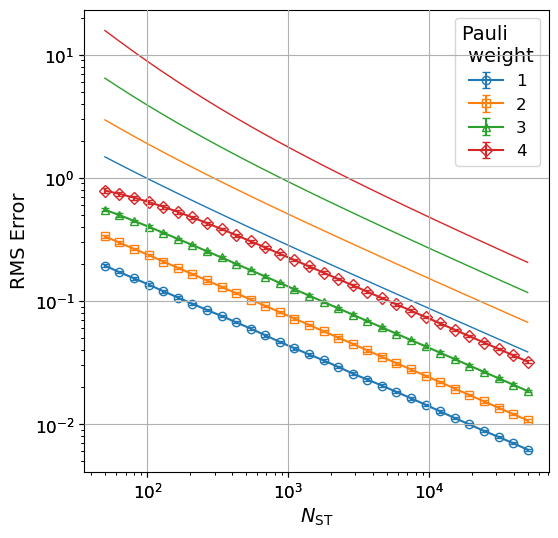

In [13]:
fig = st_error(errs, filedir=PLOT_DIR)
plt.show()

In [14]:
#filter based on exact signal variance
mask1 = (np.var(exacts, axis=0) > 1e-3) # shape: (len(Ostrings),)
print(f"inds1 retained: {100*np.sum(mask1)/len(ostrings):>10.2f}%")

#filter based on SNR prior to CS
mask2 = (errs[:, :, 6] > 1) # shape: (P, NSNUM)
print(f"inds2 retained: {100*np.sum(mask2)/(len(ostrings)*NSNUM):>10.2f}%")

mask = mask2 & mask1[:, None] # shape: (P, NSNUM)

inds1 retained:      43.48%
inds2 retained:      12.25%


In [15]:
def mask_data(mask, arr):
    mask = np.asarray(mask)
    arr = np.asarray(arr)

    assert arr.shape[:mask.ndim] == mask.shape, (
    f"mask shape {mask.shape} must match leading axes of arr {arr.shape}"
    )

    # expand mask to full dimensionality
    expand = (None,) * (arr.ndim - mask.ndim)
    return np.where(mask[(...,) + expand], arr, np.nan)

def find_minima(eind):
    # for each Ostring, shadow_sub, time_sub, find (best alpha, best error, meets threshold?)
    minima = np.full((NUM_PAULIS,NSNUM,MNUM,3), np.nan)
    for ii in tqdm(range(NUM_PAULIS), desc='Finding minima'):
        for jj in range(NSNUM):
            threshold = errs[ii, jj, eind]
            for kk in range(MNUM):
                y = cs_errs[ii, jj, kk, :, eind]
                try:
                    idx_min = np.nanargmin(y)
                    cond = y[idx_min] < threshold if eind != 6 else y[idx_min] > threshold #all error metrics except SNR: lower is better
                    minima[ii,jj,kk,:] = [alphas[idx_min], y[idx_min], cond]
                except ValueError:
                    pass
    return minima

In [16]:
eind = 2
minima = find_minima(eind=eind)

Finding minima: 100%|██████████| 1909/1909 [00:16<00:00, 112.92it/s]


In [17]:
def plot_errs_alpha(cs_errs, sind, eind, filedir=None, filename=None):
    nrows,ncols = 1,4
    fig, axes = plt.subplots(nrows,ncols,figsize=(4*ncols,4*nrows),gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    masked_errs = mask_data(mask, errs)
    masked_cs_errs = mask_data(mask, cs_errs)

    for w, inds in enumerate(get_inds(Nq)):
        if 1 <= w <= Nb:
            ax = axes[w-1]
            ax.sharey(axes[0])

            threshold = np.nanmean(masked_errs[inds, sind, eind])
            ax.axhline(y=threshold, color=f'C{w-1}', linestyle='--', label="")

            lowest_times_sub = 1e10
            for jj in range(MNUM):
                y = np.nanmean(masked_cs_errs[inds, sind, jj, :, eind], axis=0)
                if np.isfinite(y).sum() == 0:
                    continue
                
                lbl = ""
                color = f'C{w-1}'
                lw = 1
                if jj == 0 or jj == MNUM-1:
                    lbl = f'{times_subs[jj]}'

                # this works because times_subs is sorted
                if np.min(y) < threshold and times_subs[jj] < lowest_times_sub:
                    lowest_times_sub = times_subs[jj]
                    lbl = f'{times_subs[jj]}'
                    color = 'black'
                    lw = 2

                ax.plot(alphas, y, color=color, alpha=0.4, label=lbl, linewidth=lw)

            lines, labels = ax.get_legend_handles_labels()
            spots = np.logspace(-6.5, -3.25, len(lines))
            # spots = [1e-6 + (3e-3 - 1e-4) * (ii/len(lines)) for ii in range(len(lines))]
            labelLines(lines, xvals=spots)

            ax.set_xscale('log')
            ax.set_title(f'Weight {w}')
            if eind != 6:
                ax.set_yscale('log')
            if w == 1:
                ax.set_ylabel(err_key[eind])
            if w != 1:
                ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
            if w == 1:
                ax.set_xlabel(r'$\alpha$')
            ax.grid()
        
    plt.suptitle(fr"$N_{{\text{{ST}}}}={shadow_subs[sind]}$", y=1.01)
    if filedir is not None:
        os.makedirs(filedir, exist_ok=True)
        if filename is None:
            filename = f"{filedir}/cs_errs_sind={sind}_eind={eind}.png"
        else:
            filename = f"{filedir}/{filename}"  
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    return fig

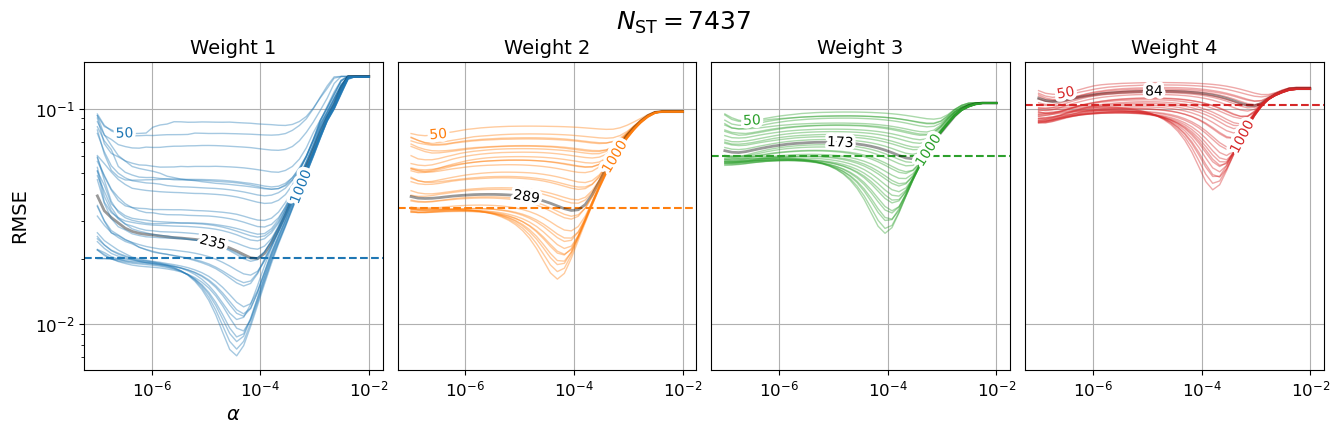

In [18]:
sind = -9
fig = plot_errs_alpha(cs_errs, 
                      sind=sind, 
                      eind=eind, 
                      filedir=PLOT_DIR_CS
                      )
plt.show()

In [19]:
def plot_errs_best(minima, tind, eind, hullall=False, filedir=None, filename=None):
    err_key = ['MAE', 'MRE', 'RMSE', 'RRMSE', 'Huber', 'Rel. Huber', 'SNR (dB)']
    nrows,ncols = 1,4
    fig, axes = plt.subplots(nrows,ncols,figsize=(4*ncols,4*nrows),gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    max_eff, min_eff = -np.inf, np.inf
    sinds = range(NSNUM)[::1]

    masked_errs = mask_data(mask, errs)
    masked_minima = mask_data(mask, minima)

    for w in range(1, Nb+1):
        inds = get_inds(Nq)[w]

        ax = axes[w-1]
        ax.sharey(axes[0])
        prev, curr = False, False
        for ii in sinds:
            do_hull = False

            xs = masked_errs[inds, ii, eind]
            ys = masked_minima[inds,ii,tind,1]

            xsp = xs[~np.isnan(ys)]
            ysp = ys[~np.isnan(ys)]

            try:
                max_eff = max(max_eff, max(xsp))
                min_eff = min(min_eff, min(xsp))
                curr = True
            except:
                continue

            if ii == NSNUM-1:
                do_hull = True
                ax.annotate(f'{shadow_subs[ii]}', 
                            xy=(xsp[np.argmax(ysp)], ysp.max()), 
                            xytext=(-5,30),
                            textcoords="offset points",
                            fontsize=12, 
                            color=f'C{w-1}',
                            arrowprops=dict(arrowstyle="->", color=f'C{w-1}'))

            
            if (prev == False and curr == True):
                do_hull = True
                ax.annotate(f'{shadow_subs[ii]}', 
                            xy=(xsp[np.argmin(ysp)], ysp.min()), 
                            xytext=(-10,-50),
                            textcoords="offset points",
                            fontsize=12, 
                            color=f'C{w-1}',
                            arrowprops=dict(arrowstyle="->", color=f'C{w-1}'))

            try:
                if hullall or do_hull:
                    points = np.vstack((xsp, ysp)).T
                    hull = ConvexHull(points)
                    for simplex in hull.simplices:
                        ax.plot(points[simplex, 0], points[simplex, 1], f'C{w-1}', alpha=0.4, lw=1)
            except:
                pass

            ax.scatter(xs, ys, s=4, marker='o', alpha=0.2, color=f'C{w-1}')
            # ax.set_ylim(bottom=1e-4, top=1)
            prev = curr

        if w == 1:
            ax.set_xlabel("ST")
            ax.set_ylabel("CSST")

        if w != 1:
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        ax.grid(which='major')
        ax.set_title(f'Weight {w}')
    
    for w in range(1, Nb+1):
        ax = axes[w-1]
        ax.plot([min_eff, max_eff], [min_eff, max_eff], 'k--', label='y = x', lw=2, alpha=0.4)

    plt.suptitle(fr"{err_key[eind]}, $m={times_subs[tind]}$", y=1.01)

    if filedir is not None:
        os.makedirs(filedir, exist_ok=True)
        if filename is None:
            filename = f"{filedir}/cs_errs_tind={tind}_eind={eind}.png"
        else:
            filename = f"{filedir}/{filename}"  
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    return fig

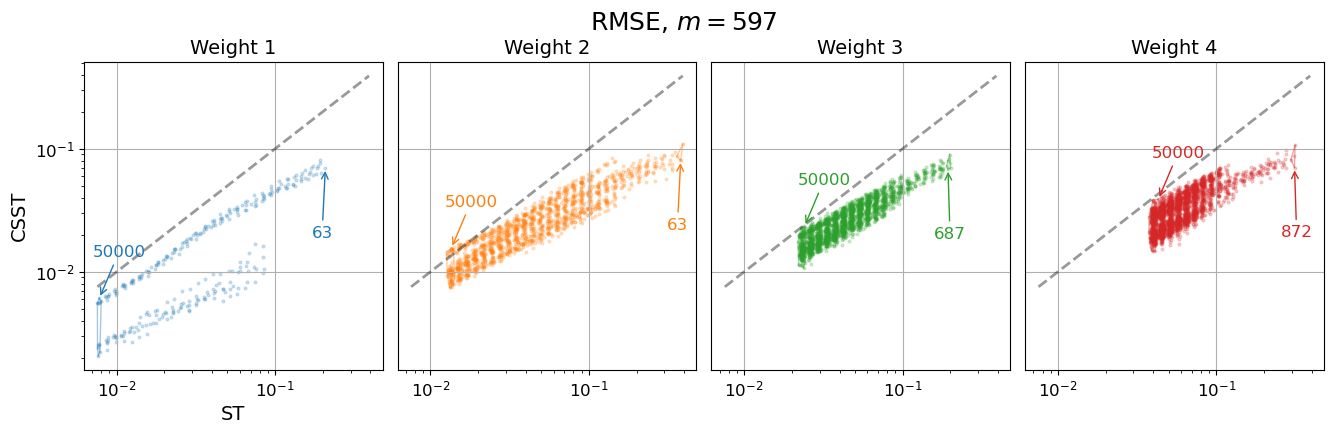

In [20]:
fig = plot_errs_best(minima, 
                     tind=-6, 
                     eind=eind, 
                     hullall=False,
                     filedir=PLOT_DIR_CS
                     )
plt.show()

In [21]:
def plot_opt_alphas(minima, sind, eind, filedir=None, filename=None, title=None, guide=None):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    masked_minima = mask_data(mask, minima)

    for w in range(1, Nb+1):
        inds = get_inds(Nq)[w]    
        vals = masked_minima[inds, sind, :, 0]
        means = np.nanmean(vals, axis=0)
        ax.plot(times_subs, means, label=f'{w}', color=f"C{w-1}", linewidth=2, marker=markers[w-1], markerfacecolor='none', markersize=6)

        stds = np.nanstd(vals, axis=0)
        ax.fill_between(times_subs, means-stds, means+stds, color=f"C{w-1}", alpha=0.15)

    ax.set_ylabel(fr"$\alpha^*$")
    ax.set_xscale('log')
    ax.set_xlabel(fr"$m$")
    ax.set_yscale('log')
    ax.set_title(title + fr", $N_{{\text{{ST}}}}={shadow_subs[sind]}$")
    ax.set_ylim(min(alphas), max(alphas))
    ax.grid()
    ax.legend(title='Pauli weight')

    if guide is not None:
        assert len(guide) == len(times_subs)
        ax.plot(times_subs, guide, 'k--', label='guide', linewidth=1)
        
    if filedir is not None:
        os.makedirs(filedir, exist_ok=True)
        if filename is None:
            filename = f"{filedir}/opt_alphas_sind={sind}_eind={eind}.png"
        else:
            filename = f"{filedir}/{filename}"  
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    return fig

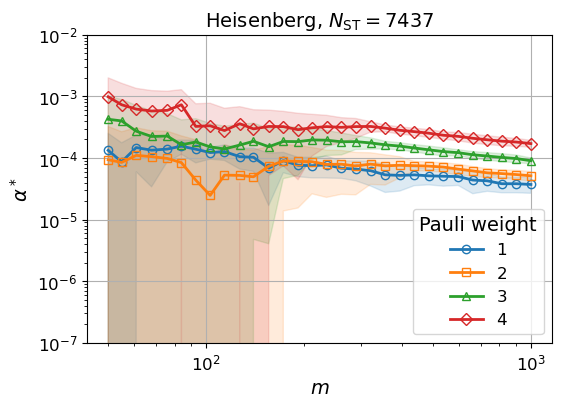

In [22]:
sind = -9
fig = plot_opt_alphas(minima, 
                      sind=sind, 
                      eind=eind, 
                      filedir=PLOT_DIR_CS, 
                      title=models[HAM],
                      # guide=times_subs**(-3/2)
                      )
plt.show()

In [23]:
def plot_reduction_factors(minima, eind, filedir=None, filename=None):
    fig, axes = plt.subplots(1,4,figsize=(16,4),gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
    masked_errs = mask_data(mask, errs)
    masked_minima = mask_data(mask, minima)
    for w in range(1,Nb+1):
        ax = axes[w-1]
        ax.sharey(axes[0])
        inds = get_inds(Nq)[w]

        for sind in range(NSNUM):
            factors = np.zeros((MNUM,))
            for tind in range(MNUM):
                Nratio = max(times_subs) / times_subs[tind]
                Eratios = (masked_errs[inds,sind,eind] / masked_minima[inds,sind,tind,1])**2
                factors[tind] = Nratio * np.nanmean(Eratios)
            if not np.all(np.isnan(factors)):
                ax.plot(times_subs, factors, label=f'{shadow_subs[sind]}', color=f'C{w-1}', alpha=0.5)
        try:
            labelLines(ax.get_lines()[::6], fontsize=10)
        except:
            pass    

        ax.set_title(f'Weight {w}')
        if w == 1:
            ax.set_ylabel(r'Shot reduction factor (SRF)')
            ax.set_xlabel(r'$m$')
        if w != 1:
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.plot(times_subs, np.sqrt(max(times_subs)/times_subs), color='k', linestyle='--', label=r'$N/m$', lw=2, alpha=0.4)
        ax.grid()

    if filedir is not None:
        os.makedirs(filedir, exist_ok=True)
        if filename is None:
            filename = f"{filedir}/rfs_eind={eind}.png"
        else:
            filename = f"{filedir}/{filename}"  
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    return fig


/var/folders/2q/925k9byj00g101q99sk75gxh0000gn/T/ipykernel_71909/1537942223.py:15: RuntimeWarning: Mean of empty slice
  factors[tind] = Nratio * np.nanmean(Eratios)


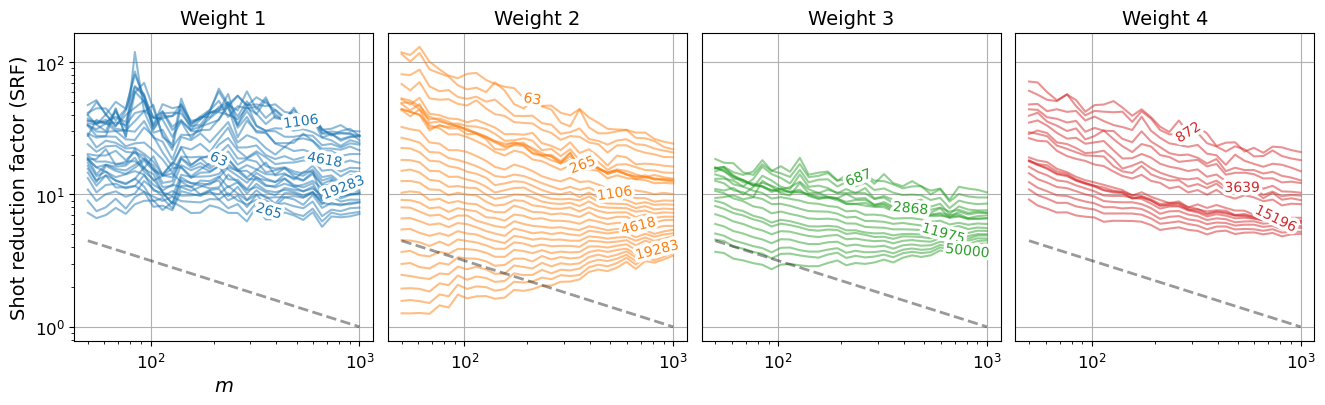

In [24]:
fig = plot_reduction_factors(minima, 
                             eind=eind, 
                             filedir=PLOT_DIR_CS,
                             )
plt.show()

Need to find alpha by sweeping: N_ST=265, m=597, op=XXXIII


100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


Need to find alpha by sweeping: N_ST=265, m=597, op=XXXXII


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


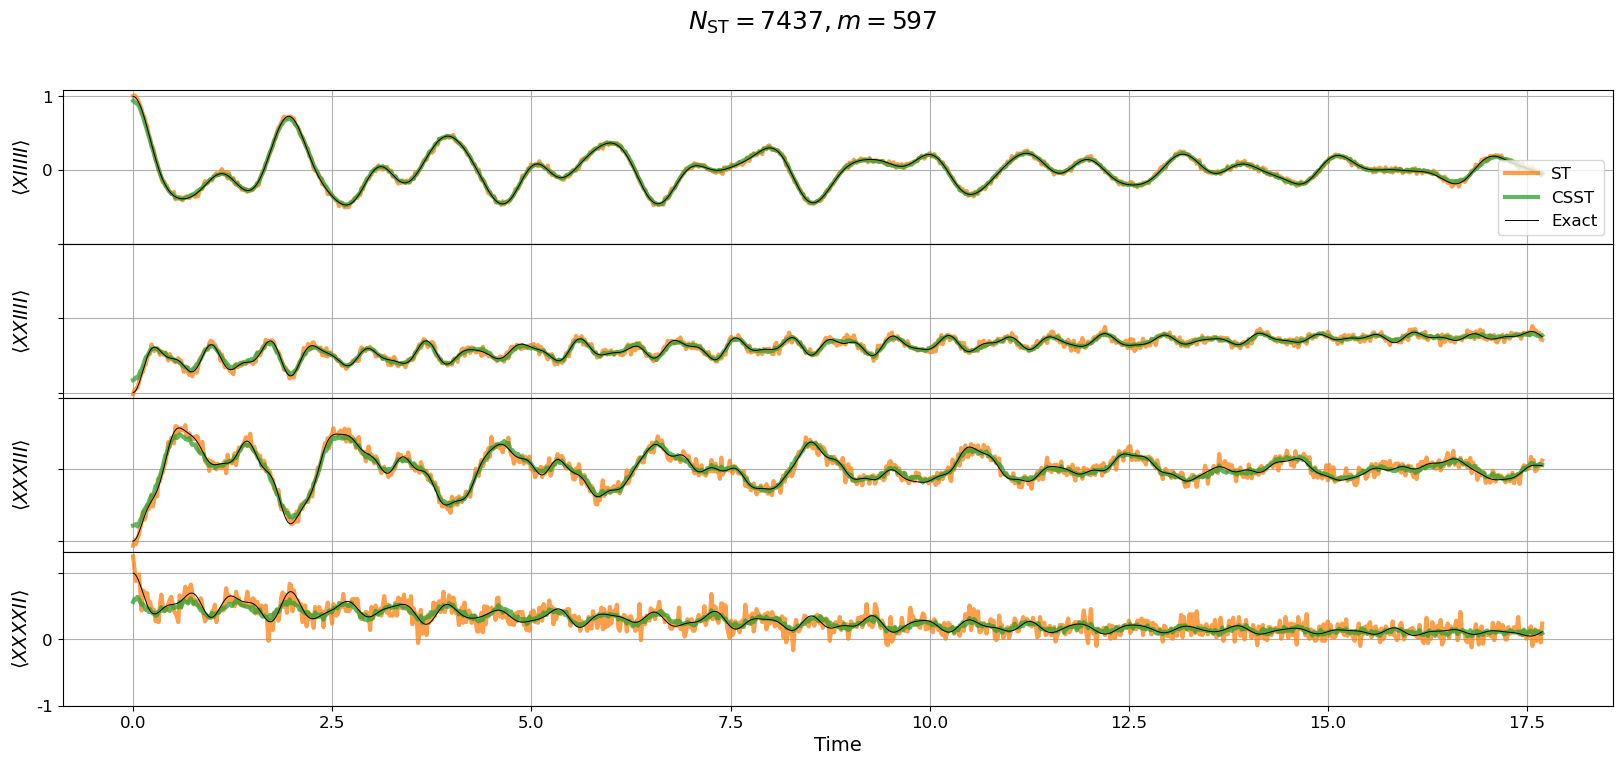

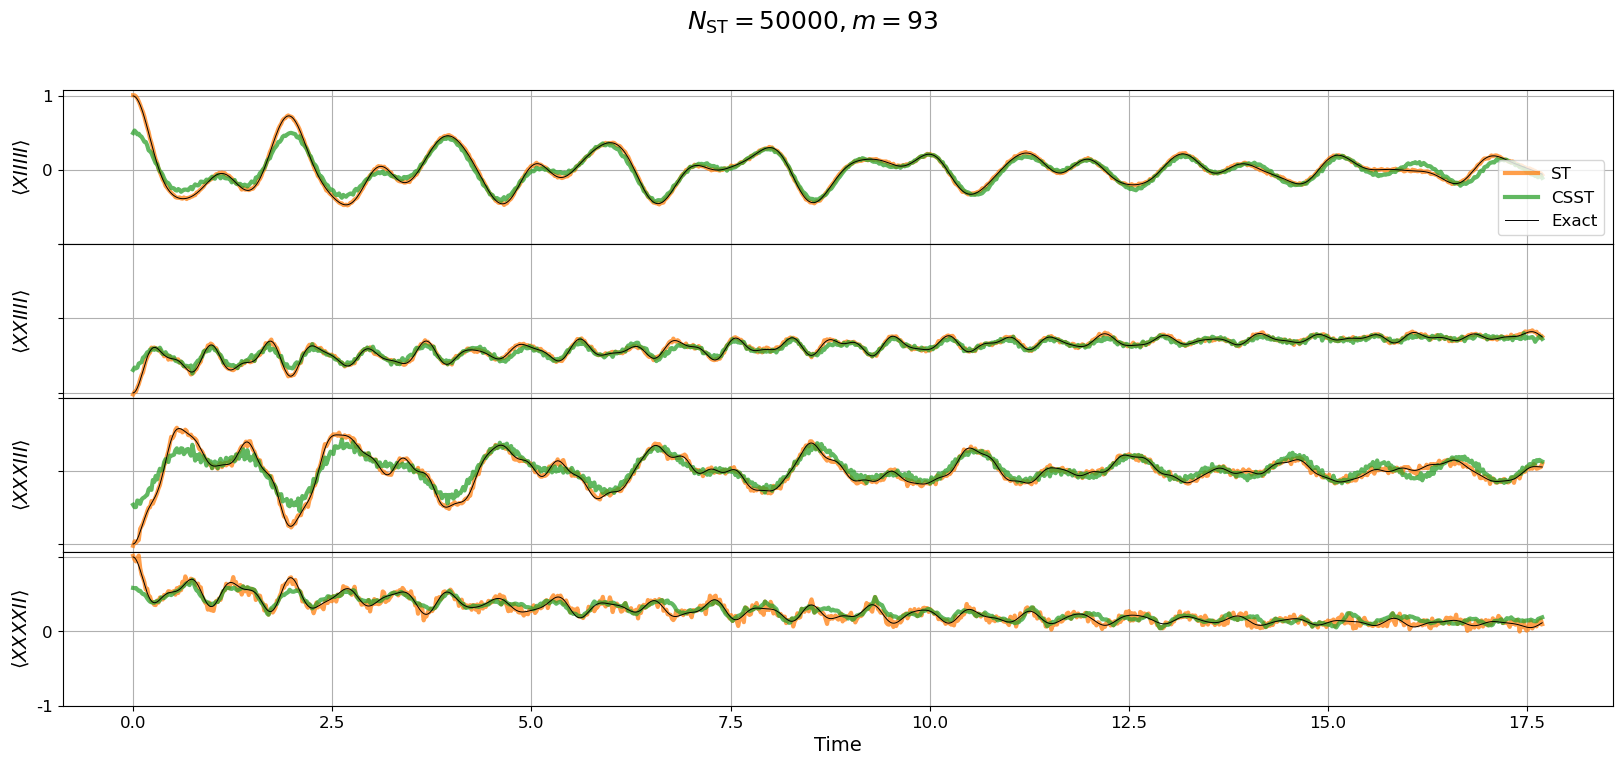

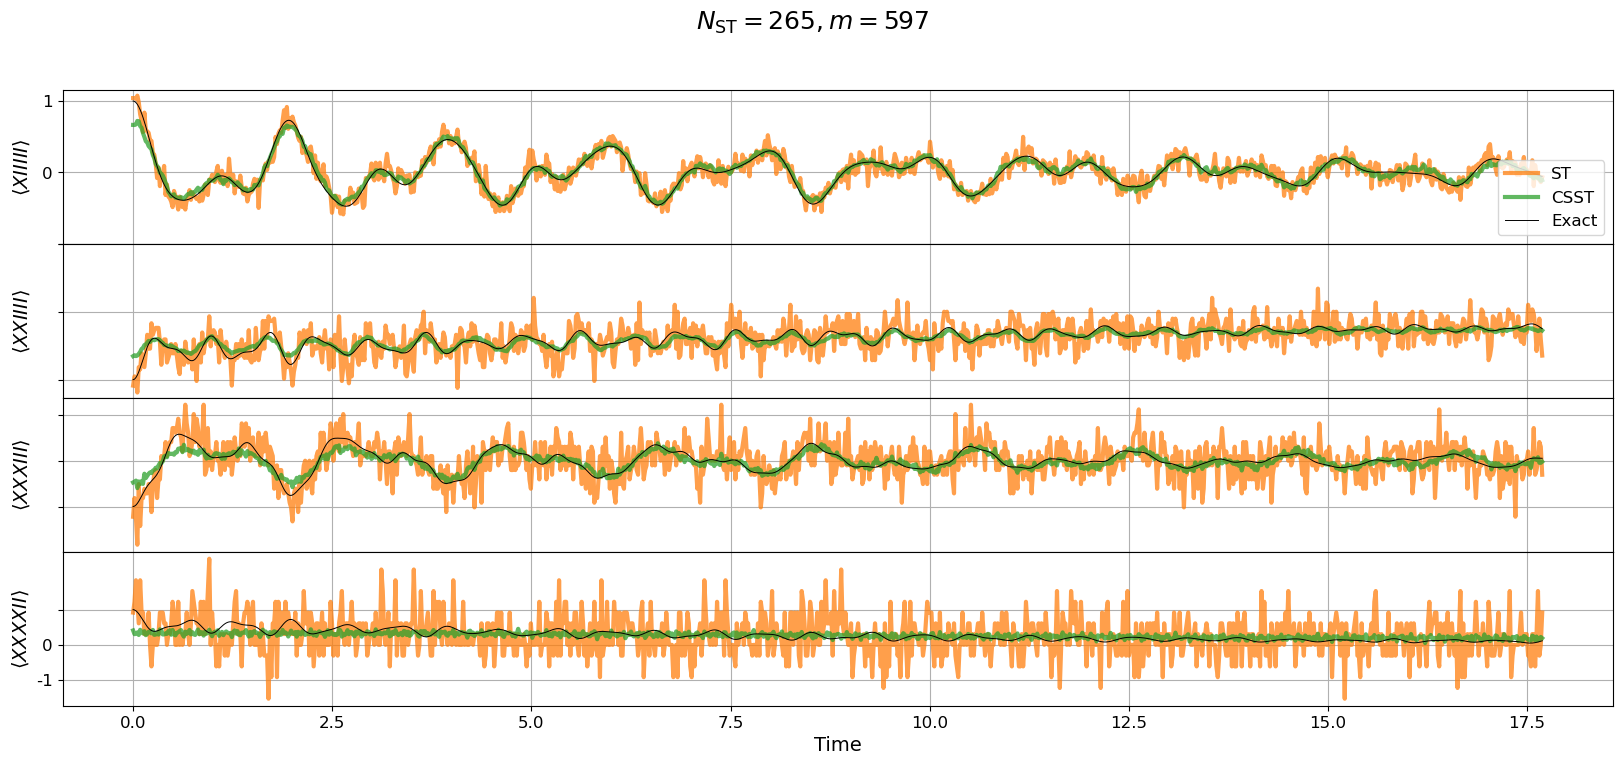

In [26]:
ostrings_to_plot = ['XIIIII', 'XXIIII', 'XXXIII', 'XXXXII']
# ostrings_to_plot = ['YIIIII', 'YYIIII', 'YYYIII', 'YYYYII']
# ostrings_to_plot = ['ZIIIII', 'ZZIIII', 'ZZZIII', 'ZZZZII']

# ostrings_to_plot = ['ZIII', 'ZZII', 'ZZZI', 'ZZZZ']
# ostrings_to_plot = ['YIII', 'YYII', 'YYYI', 'YYYY']
# ostrings_to_plot = ['XIII', 'XXII', 'XXXI',  'XXXX']

oinds = np.array([ostrings.index(s) for s in ostrings_to_plot], dtype=int)
examples = [(-9,-6),(-1,6),(7,-6)] #(sind, tind)

for idx, (sind, tind) in enumerate(examples):
    recons = np.zeros((len(times), len(oinds)), dtype=complex)
    for ii, oind in enumerate(oinds):
        alpha = minima[oind,sind,tind,0]
        bp_func = lambda alpha: basis_pursuit(times, 
                                      num_samps=times_subs[tind], 
                                      data=ests[:,oind,sind], 
                                      alpha=alpha, 
                                      seed=42,
                                      rescale=params['rescale'],
                                      inverse=params['inverse'],
                                      fit_intercept=params['fitint'],
                                      replace=params['replace']
                                      )
        
        if np.isnan(alpha):
            print(f"Need to find alpha by sweeping: N_ST={shadow_subs[sind]}, m={times_subs[tind]}, op={ostrings[oind]}")
            (alpha, recon, err), errors = alpha_sweep(alphas, bp_func, exacts[:,oind], eind=2)
        else:
            recon, _ = bp_func(alpha)
        recons[:, ii] = recon
    fig = plot_observables(times, ostrings_to_plot, exacts[:,oinds], ests[:,oinds,sind], recons.T.real)
    fig.suptitle(fr"$N_{{\text{{ST}}}}={shadow_subs[sind]}, m={times_subs[tind]}$")

    filename = PLOT_DIR_CS / f'examples_cs_{idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')